# Generate data for sparse coding with autoencoder

We select a few continuous measures, like heart rate, sBP, dBP, SpO2, and RR

Created: 2019-01-17

# Methods

In [3]:
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [191]:
def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    """Pads sequences to the same length.

    This function transforms a list of
    `num_samples` sequences (lists of integers)
    into a 2D Numpy array of shape `(num_samples, num_timesteps)`.
    `num_timesteps` is either the `maxlen` argument if provided,
    or the length of the longest sequence otherwise.

    Sequences that are shorter than `num_timesteps`
    are padded with `value` at the end.

    Sequences longer than `num_timesteps` are truncated
    so that they fit the desired length.
    The position where padding or truncation happens is determined by
    the arguments `padding` and `truncating`, respectively.

    Pre-padding is the default.

    # Arguments
        sequences: List of lists, where each element is a sequence.
        maxlen: Int, maximum length of all sequences.
        dtype: Type of the output sequences.
        padding: String, 'pre' or 'post':
            pad either before or after each sequence.
        truncating: String, 'pre' or 'post':
            remove values from sequences larger than
            `maxlen`, either at the beginning or at the end of the sequences.
        value: Float, padding value.

    # Returns
        x: Numpy array with shape `(len(sequences), maxlen)`

    # Raises
        ValueError: In case of invalid values for `truncating` or `padding`,
            or in case of invalid shape for a `sequences` entry.
    """
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((num_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x


In [4]:
def _total_minutes(td):
    return td.total_seconds() / 60
def total_minutes(td):
    return td.apply(_total_minutes)
def _total_hours(td):
    return td.total_seconds() / 60 / 60
def total_hours(td):
    return td.apply(_total_hours)
def _total_days(td):
    return td.total_seconds() / 60 / 60 / 24
def total_days(td):
    return td.apply(_total_days)

def from_julian_time(z):
    return pd.to_datetime(z - pd.Timestamp(0).to_julian_date(), unit='D')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 72

# green, red, blue, yellow, purple, blue, grey
flatui = ["#2DEC2A","#F6204F","#33CCFF","#FFCC33","#9b59b6","#25BCFE","#95a5a6"]
default_colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF","#F9AE23"]

def fontsize(ax, fz = 14):
    """Set all fontsizes to fz"""
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fz)

def labels(ax, title=None, subtitle=None, xlabel=None, ylabel=None, xticklabels = None, legend_title = None, legend_labels=None, legend_loc = 'upper right', fz=14, grid=True):
    """Assign titles and labels.
    xticklabels and legend_labels should be lists, all others are strings."""
    if title is not None:
        if subtitle is None:
            plt.title(title)
        else:
            plt.suptitle(title, y=1, fontsize=fz+2)
            plt.title(subtitle)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if legend_title is not None and legend_labels is not None:
        handles, ax_legend_labs = ax.get_legend_handles_labels()
        ax.legend(handles, legend_labels, title=legend_title, loc=legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel);
    if ylabel is not None:
        plt.ylabel(ylabel);
    if grid:
        plt.grid(linestyle='dotted')
    fontsize(ax, fz)

def annotate(ax, x, y, text, offset=5):
    """Place text in different locations of the plot.
    x and y are lists of locations on the plot. text can be a list of numbers or strings."""
    for i in range(len(x)):
        ax.text(x[i], y[i]+offset, text[i], bbox={'facecolor':'white','pad':5}, horizontalalignment='center')

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [6]:
from scipy import stats
EPS = 1e-12
def robust_transform(x, rescale=True):
    h = 1/(1 + np.exp( - (x-np.nanmedian(x)) / (1.35 * stats.iqr(x[np.isfinite(x)]) + EPS) ))
    if rescale:
        h = (h - np.nanmin(h)) / (np.nanmax(h) - np.nanmin(h))
    return h

In [11]:
def squared_exponential(distance, alpha=1):
    return np.exp((distance*alpha)**2 / -2)

# Load data

In [7]:
PATH = '/local/home/Asif/data/ards/'
files = [f for f in os.listdir(PATH) if f.endswith('.csv')]
print(len(files))

71972


In [8]:
parameters = ['FiO2', 'PaO2', 'PaCO2', 'pH', 'HR', 'RespRate', 'SpO2', 'NISysABP', 'NIDiaABP', 'NIMeanABP', 'Glucose', 'Temp', 'PEEP', 'BUN', 'Calcium', 'Creatinine', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Potassium', 'Sodium', 'WBC', 'Albumin', 'Bilirubin', 'ALT', 'AST', 'ALP', 'Lactate', 'INR', 'TotalCO2', 'ISysABP', 'IDiaABP', 'IMeanABP', 'PTT', 'Bands', 'TVInsp', 'SaO2', 'PAPMean', 'PAPDia', 'PAPSys', 'PPlat', 'MAWP']

def load_file(f):
    df = pd.read_csv(PATH + f)
    pid = df.loc[df.Parameter == 'patientUnitStayID'].iloc[0].Value
    label_28day_mortality = float(df[df.Parameter == 'label_28day_mortality'].iloc[0].Value)
    timeOfID = float(df.loc[df.Parameter == 'timeOfID','Value'].iloc[0])
    df = df.loc[(df.Time>=timeOfID) & (df.Time<=(timeOfID+24*60)) & (df.Parameter.isin(parameters))].sort_values('Time').reset_index(drop=True).copy()
    df.loc[:,'Value'] = df.loc[:,'Value'].astype(float)
    df.loc[:,'Time'] = df.loc[:,'Time'] - timeOfID # time in minutes from ID
    df = df.assign(TimeStamp=[pd.Timestamp('2018-01-01') + pd.Timedelta(f'{t}m') for t in df.Time])
    return df, (pid, label_28day_mortality, timeOfID)

Not enough samples
[0.34 1.15 2.35]


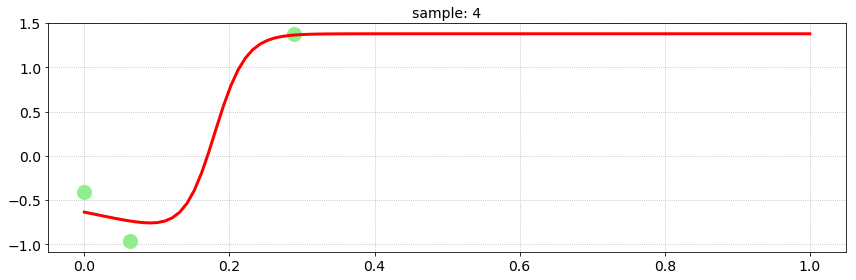

In [233]:
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel,additive_chi2_kernel
from sklearn.metrics import pairwise_distances

min_num_samples = 3
timesteps = 48

i = 4

df, meta = load_file(files[i])
dx = df[df.Parameter == 'ISysABP']
if len(dx) >= min_num_samples:
    x = dx.set_index('TimeStamp')
    x = x.Value.round(2)
    xz = ((x - np.nanmean(x)) / np.nanstd(x)) if np.sum(np.diff(x.values)) != 0 else x * 0 # zscore
    t = total_minutes(pd.Series(xz.index - xz.index[0])).values
    t = t[:,np.newaxis]/1440
    x = xz.values[:,np.newaxis]
else:
    print('Not enough samples')

# kernel smoothing
alpha = 30
r = np.atleast_2d(np.linspace(0,1,100)).T

w = np.sqrt(np.square(r - t.T))
wi = w.sum(1)
alpha = [np.quantile(wi, 0.1), np.quantile(wi, 0.5), np.quantile(wi, 0.9)]
print(np.round(alpha,2))
alpha = alpha[2]

# Krt = squared_exponential(w, alpha)
Krt = rbf_kernel(r,t,100)
xh = np.sum(Krt * x.T,1) / Krt.sum(1)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
plt.plot(t, x,'o',color='lightgreen',ms=14, label='measured')
plt.plot(r, xh,'-',color='red',lw=3)
labels(ax, title=f'sample: {i}')
plt.tight_layout()

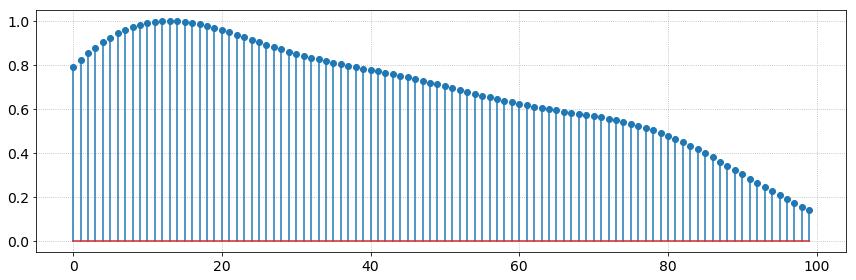

In [173]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
wi = Krt.sum(1)
wi = wi / wi.max()
plt.stem(wi)
labels(ax)
plt.tight_layout()

In [260]:
def gendata(f):
    df, meta = load_file(f)
    X = []
    T = []
    feats = []
    for f in ['HR','SpO2','NISysABP','RespRate','SaO2']:
        dx = df[df.Parameter == f]
        if len(dx) > min_num_samples:
            x = dx.set_index('TimeStamp')
            x = x.Value.round(2)
            t = total_minutes(pd.Series(x.index - x.index[0])).values
            t = t[:,np.newaxis]/1440
            if np.isnan(x).sum() == len(x):
                continue
            X.append(x.values[:,np.newaxis])
            T.append(t)
            feats.append(f)
    if len(X) > 0:
        return {'values':X, 'times':T, 'features':feats, 'pid': meta[0]}
    else:
        return None

In [261]:
out = gendata(files[4])

In [291]:
import multiprocessing
from tqdm import tqdm

data = {'values':[],'times':[],'features':[],'pid':[]}

pool = multiprocessing.Pool(processes=12)
with tqdm(total=len(files)) as progress_bar:
    for out in pool.imap_unordered(gendata, files):
        if out is not None:
            data['values'].extend(out['values'])
            data['times'].extend(out['times'])
            data['features'].extend(out['features'])
            data['pid'].extend([out['pid']] * len(out['features']))
        progress_bar.update(1)

100%|██████████| 71972/71972 [06:25<00:00, 186.57it/s]


In [292]:
pool.close()

In [293]:
!free -hm

              total        used        free      shared  buff/cache   available
Mem:           251G        8.8G        231G        124M         11G        241G
Swap:           31G          0B         31G


In [294]:
len(data['values'])

313368

In [296]:
import deepdish as dd
dd.io.save('/local/home/Asif/data/tmp/ards_irregular.h5', data)

In [297]:
!ls -lafgh /local/home/Asif/data/tmp/

total 1.1G
drwxr-xr-x 2 upb-dept  246 Jan 17 15:01 .
drwxr-xr-x 4 upb-dept   29 Jan  3 15:46 ..
-rw-r--r-- 1 upb-dept  27M Jan  7 11:37 ards_hr.npy
-rw-r--r-- 1 upb-dept  26M Jan  4 15:18 ards_hr_gpinterp.npy
-rw-r--r-- 1 upb-dept 274K Jan  7 11:37 ards_hr_patientUnitStayIDs.npy
-rw-r--r-- 1 upb-dept  22M Jan  7 12:03 ards_SpO2.npy
-rw-r--r-- 1 upb-dept 226K Jan  7 12:03 ards_SpO2_patientUnitStayIDs.npy
-rw-r--r-- 1 upb-dept  18M Jan  7 13:12 ards_NISysABP.npy
-rw-r--r-- 1 upb-dept 180K Jan  7 13:12 ards_NISysABP_patientUnitStayIDs.npy
-rw-r--r-- 1 upb-dept 941M Jan 17 15:35 ards_irregular.h5
